<a href="https://colab.research.google.com/github/tsdes-santiago/projetos_bootcamp_DIO/blob/main/Deteccao_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formação Machine Learning Specialist

## Criação de Uma Base de Dados e Treinamento da Rede YOLOv3

Nesse notebook descrevo como preparar as imagens com anotações baixadas do repositório Open Images Dataset V5 para o treinamento com a rede Yolov3.

O treinamento excedeu o tempo da conta gratuita com o colab, então abortei o treinamento e não pude ver o resultado.


## Preparando a rede YOLOv3

In [2]:
#Checando a versão do cuda
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
# baixando a rede  YOLOv3
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955
Receiving objects: 100% (5955/5955), 6.37 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (3932/3932), done.


In [4]:
%cd darknet

/content/darknet


In [5]:
# mudando makefile para habilitar GPU e OPENCV
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

Habilitar GPU em Edit -> Notebook settings

In [6]:
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -c ./src/gemm.c -o obj/gemm.o
Package opencv was not found in the pkg-config search path.
Perhaps you should add the directory containing `opencv.pc'
to the PKG_CONFIG_PATH environment variable
No package 'opencv' found
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wdeprecated-declarations-Wdeprecated-declarations]8;;]
  232 |         cudaThreadSynchronize();
      |         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:95,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_a

Aparentemente o erro é causado pela versão do cudnn, nos exeplos que vi na internet usam a versão para cuda 10, aqui no colab já está no cuda 12.2

Como não é recomendado fazer downgrade do cuda no colab vou voltar para CPU.

In [13]:
# mudando makefile para habilitar CPU
!sed -i 's/OPENCV=1/OPENCV=0/' Makefile
!sed -i 's/GPU=1/GPU=0/' Makefile
!sed -i 's/CUDNN=1/CUDNN=0/' Makefile

In [14]:
!make

gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o obj/image.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wn

### Baixando os pesos da rede já treinada




In [11]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2024-02-29 13:20:32--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  9.83MB/s    in 34s     

2024-02-29 13:22:16 (6.95 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



### Testando a detecção com uma imagem

In [15]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

In [16]:
#Visualizando o resultado
import matplotlib.pyplot as plt

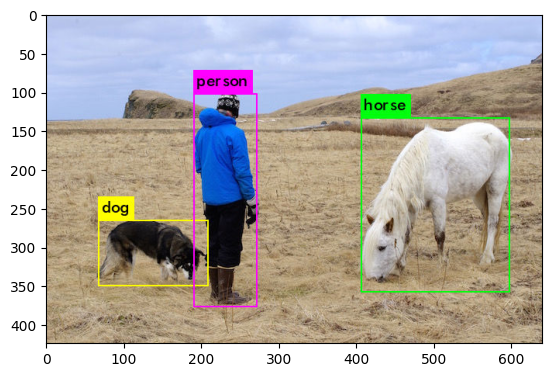

In [17]:
image = plt.imread('predictions.jpg')
plt.figure()
plt.imshow(image)
plt.show()

## Baixando as imagens para treinamento

Seguindo o tutorial em https://www.youtube.com/watch?v=_4A9inxGqRM com o pacote https://github.com/theAIGuysCode/OIDv4_ToolKit para download das imagens com anotações.

In [18]:
!pwd

/content/darknet


In [19]:
# Criando diretório para salvar as imagens
!mkdir dataset_train

In [20]:
%cd dataset_train/

/content/darknet/dataset_train


In [21]:
!git clone https://github.com/theAIGuysCode/OIDv4_ToolKit.git

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 444, done.
remote: Total 444 (delta 0), reused 0 (delta 0), pack-reused 444
Receiving objects: 100% (444/444), 34.09 MiB | 19.95 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [22]:
%cd OIDv4_ToolKit/

/content/darknet/dataset_train/OIDv4_ToolKit


In [23]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.18.1
    Uninstalling docutils-0.18.1:
      Successfully uninstalled docutils-0.18.1


In [24]:
# Baixando no máximo 30 imagens de espadas e de Bandeiras para validação
!python main.py downloader --classes Flag Sword --type_csv validation --multiclasses 1 --limit 30 --y


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading ['Flag', 'Sword'] together.
   [ERROR] | Missing the class-descriptions-boxable.csv file.
[DOWNLOAD] | Automatic download.
...145%, 0 MB, 40256 KB/s, 0 seconds passed
[DOWNLOAD] | File class-descr

In [25]:
# Baixando no máximo 100 imagens para treinamento
!python main.py downloader --classes Flag Sword --type_csv train --multiclasses 1 --limit 100 --y


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading ['Flag', 'Sword'] together.
   [ERROR] | Missing the train-annotations-bbox.csv file.
[DOWNLOAD] | Automatic download.
...100%, 1138 MB, 30334 KB/s, 38 seconds passed
[DOWNLOAD] | File train-annot

**Modificar manualmente o arquivo classes.txt em OIDv4_ToolKit**

Flag  
Sword

In [26]:
#Convertendo anotacões para formato Yolov3
!python convert_annotations.py

Currently in subdirectory: validation
Converting annotations for class:  Flag_Sword
100% 51/51 [00:01<00:00, 43.26it/s]
Currently in subdirectory: train
Converting annotations for class:  Flag_Sword
100% 200/200 [00:08<00:00, 22.22it/s]


**Checando as bounding boxes em um arquivo aleatório**

In [27]:
import os
from matplotlib.patches import Rectangle
import numpy as np

In [28]:
#Escolhendo caminho das imagens
#validation
#image_path = 'OID/Dataset/validation/Flag_Sword/'
#train
image_path = 'OID/Dataset/train/Flag_Sword/'

In [29]:
# Obtendo os nomes dos arquivos no diretório removendo a extenção .txt
names_list = []
for f_name in os.listdir(image_path):
    if f_name.endswith(".txt"):
        names_list.append(f_name[:-4])

In [30]:
# Escolhendo um arquivo aleatóriamente para plotar
name = names_list[np.random.randint(len(names_list))]

In [31]:
ann = np.loadtxt(image_path+name+'.txt')

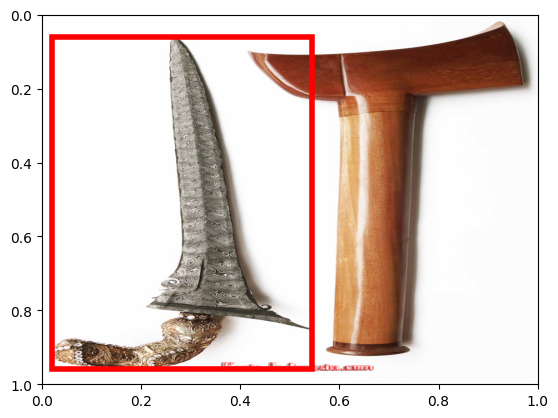

In [32]:
image = plt.imread(image_path+name+'.jpg')
plt.figure()
plt.imshow(image, extent=[0,1,1,0], aspect='auto')
#add rectangle
if len(ann.shape) == 1:
    plt.gca().add_patch(Rectangle((ann[1]-ann[3]/2,ann[2]-ann[4]/2),ann[3],ann[4],
                    edgecolor='red',
                    facecolor='none',
                    lw=4))

else:
    for i in range(len(ann)):
        plt.gca().add_patch(Rectangle((ann[i,1]-ann[i,3]/2,ann[i,2]-ann[i,4]/2),ann[i,3],ann[i,4],
                        edgecolor='red',
                        facecolor='none',
                        lw=4))

plt.show()

## Preparando pastas e arquivos para treinamento

In [33]:
!pwd

/content/darknet/dataset_train/OIDv4_ToolKit


In [34]:
%cd /content/darknet

/content/darknet


In [35]:
# Criando o diretório para treinamento
!mkdir custom_dataset
# Diretório para salvar imagens e anotações
!mkdir custom_dataset/data
!mkdir custom_dataset/data/images
!mkdir custom_dataset/data/labels

In [36]:
dataset_path = '/content/darknet/custom_dataset/'

In [37]:
classes_list = ['Flag', 'Sword']

In [38]:
#Criando o arquivo classes.names
with open(dataset_path+'classes.names', 'w') as file:
    for name in classes_list:
        print(name, file=file)

In [39]:
#Criando o arquivo val.txt e copiando as imagens e anotações
val_path = '/content/darknet/dataset_train/OIDv4_ToolKit/OID/Dataset/validation/Flag_Sword/'
for f_name in os.listdir(val_path):
    if f_name.endswith(".txt"):
        #append image path to val.txt file
        with open(dataset_path + 'val.txt', 'a') as file:
            file.write(dataset_path+'data/images/'+f_name[:-4]+'.jpg\n')
        #copy image to images directory
        os.system('cp '+val_path+f_name[:-4]+'.jpg '+dataset_path+'data/images')
        #copy txt
        os.system('cp '+val_path+f_name+' '+dataset_path+'data/images')

In [40]:
#Criando o arquivo train.txt e copiando as imagens e anotações
train_path = '/content/darknet/dataset_train/OIDv4_ToolKit/OID/Dataset/train/Flag_Sword/'
for f_name in os.listdir(train_path):
    if f_name.endswith(".txt"):
        #append image path to val.txt file
        with open(dataset_path + 'train.txt', 'a') as file:
            file.write(dataset_path+'data/images/'+f_name[:-4]+'.jpg\n')
        #copy image to images directory
        os.system('cp '+train_path+f_name[:-4]+'.jpg '+dataset_path+'data/images')
        #copy txt
        os.system('cp '+train_path+f_name+' '+dataset_path+'data/labels')

In [41]:
#criando diretorio do arquivo de configuração e copiando o arquivo
!mkdir /content/darknet/custom_dataset/data/cfg
!cp /content/darknet/cfg/yolov3.cfg /content/darknet/custom_dataset/data/cfg/yolov3-retrain.cfg

### Modifico manualmento o arquivo yolov3-retrain.cfg

20 max_batches = classes*2000 = 4000 (2 classes nesse caso )

22 steps=3200,3600 (80%, 90% de max_batches)

classes=2 (linhas 610, 696, 783)

filters = (classes +5)*3 = 21 (linhas 603, 689, 776)

In [42]:
# Criando pasta backup para salvar os pesos do treinamento
!mkdir /content/darknet/custom_dataset/data/backup

In [43]:
#criando o arquivo retrain.data
retrain = open("/content/darknet/custom_dataset/data/retrain.data", "w")
retrain.write("classes=2\n")
retrain.write("train=/content/darknet/custom_dataset/train.txt\n")
retrain.write("val=/content/darknet/custom_dataset/val.txt\n")
retrain.write("names=/content/darknet/custom_dataset/classes.names\n")
retrain.write("backup=/content/darknet/custom_dataset/data/backup")
retrain.close()

## Treinamento com transfer learning

In [44]:
# Baixando os pesos para o treinamento
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2024-02-29 13:36:54--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  12.6MB/s    in 23s     

2024-02-29 13:37:48 (6.77 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [45]:
# Treinando a deteção das novas classes
!./darknet detector train custom_dataset/data/retrain.data custom_dataset/data/cfg/yolov3-retrain.cfg darknet53.conv.74

yolov3-retrain
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8        

***O treinamento demora muito, no meu computador pessoa, com um ryzen 7 5800U não terminou rodando por 3 dias. Abortei o treinamento.***

## Testando a detecção

In [46]:
#Baixando imagem de espada para teste
!wget -c https://www.sanpedrocalendar.com/wp-content/uploads/2018/11/Swords-Sword-Fighting.jpg -O sword_test.jpg

--2024-02-29 13:40:53--  https://www.sanpedrocalendar.com/wp-content/uploads/2018/11/Swords-Sword-Fighting.jpg
Resolving www.sanpedrocalendar.com (www.sanpedrocalendar.com)... 66.33.199.114
Connecting to www.sanpedrocalendar.com (www.sanpedrocalendar.com)|66.33.199.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148722 (145K) [image/jpeg]
Saving to: ‘sword_test.jpg’

sword_test.jpg      100%[===================>] 145.24K   377KB/s    in 0.4s    

2024-02-29 13:40:54 (377 KB/s) - ‘sword_test.jpg’ saved [148722/148722]



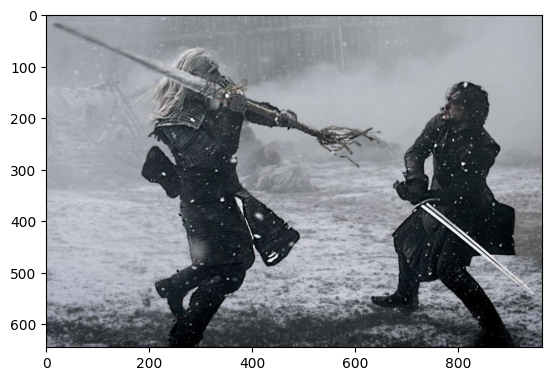

In [48]:
image = plt.imread('sword_test.jpg')
plt.figure()
plt.imshow(image)
plt.show()

In [52]:
#Testando a detecção
!./darknet detect custom_dataset/data/cfg/yolov3-retrain.cfg custom_dataset/data/backup/yolov3-retrain_100.weights sword_test.jpg -thresh 0.80

In [51]:
# Show the result
image = plt.imread('predictions.jpg')
plt.figure()
plt.imshow(image)
plt.show()